# Introducción

En un estudio sobre consumo de agua (m$^2$/mes) en cierta ciudad se supuso que el consumo estaría relacionado con el correspondiente consumo de energía eléctrica (kW/h). Construya un modelo que relacione ambos consumos, considerando el consumo de agua como la respuesta.

# a) Grafique los datos y comente.

In [3]:
# Importación de librerías y configuraciones generales.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

pd.options.display.precision = 2 # Para 2 decimales.

"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Options
params = {'font.family':'STIXGeneral',
          'text.usetex' : True,
          'font.size' : 11,
          #'figure.dpi':100
          }

plt.rcParams.update(params) 
"""

"\n%matplotlib inline\n%config InlineBackend.figure_format = 'retina'\n\n#Options\nparams = {'font.family':'STIXGeneral',\n          'text.usetex' : True,\n          'font.size' : 11,\n          #'figure.dpi':100\n          }\n\nplt.rcParams.update(params) \n"

In [ ]:
def get_x_bar(df, x):
    return df[x].mean()

def get_y_bar(df, y):
    return df[y].mean()

def get_S_xx(df, x):
    return ((df[x] - x_bar(df, x))**2).sum()

def fit(df, x, y):
    """
    df: DataFrame con la columna del regresor y la columna de la variable respuesta.
    x:  str con el nombre de la columna del regresor.
    y:  str con el nombre de la columna de la variable respuesta.
    """
    x_bar = get_x_bar(df, x) # Promedio de observaciones del regresor.
    y_bar = get_y_bar(df, y) # Promedio de observaciones de la variable respuesta.

    S_xy = (df[y]*(df[x] - x_bar)).sum()
    S_xx = get_S_xx(df, x)

    beta_1 = S_xy/S_xx # Estimador de mínimos cuadrados de la pendiente del modelo de regresión lineal.
    beta_0 = y_bar - beta_1*x_bar  # Estimador de mínimos cuadrados del intercept del modelo de regresión lineal.

    y_fit = beta_0 + beta_1*df[x] # Ajuste de regresión lineal
    y_fit.rename("y_fit", inplace = True)
    
    return y_fit, beta_0, beta_1

def get_SS_res(df, y, y_fitted):
    """
    df:       DataFrame con la columna de la variable respuesta y la columna de la respuesta ajustada.
    y:        str con el nombre de la columna de la variable respuesta.
    y_fitted: str con el nombre de la columna de la respuesta ajustada.
    """
    return sum((df[y] - df[y_fitted])**2)

def get_MS_res(df, y, y_fit):
    n = len(df.index) # Número de observaciones
    return (1/(n-2))*get_SS_res(df, y, y_fit)

def test_beta_0(df, x, y, y_fit, beta_0, beta_0_test = 0, alpha = 0.05):
    n = len(df.index) # Número de observaciones
    
    x_bar = get_x_bar(df, x)
    S_xx = get_S_xx(df, x)
    MS_res = get_MS_res(df, y, y_fit)
    
    t_0 = np.round((beta_0 - beta_0_test)/(np.sqrt(MS_res*(1/n + x_bar**2/S_xx))), 2)
    nu = n - 2
    test_statistic = np.round(stats.t.ppf(alpha/2, nu), 2)
    
    if abs(t_0) > test_statistic:
        print(f"Como |t_0| = {abs(t_0)} > {test_statistic} = t(𝛼/2, n-2), se rechaza la hipótesis nula H_0: 𝛽_0 = {beta_0_test}")
    else:
        print(f"Como |t_0| = {abs(t_0)} <= {test_statistic} = t(𝛼/2, n-2), NO se rechaza la hipótesis nula H_0: 𝛽_0 = {beta_0_test}")
    return t_0, test_statistic

def test_beta_1(df, x, y, y_fitted, beta_1, beta_1_test = 0, alpha = 0.05):
    n = len(df.index) # Número de observaciones
    
    S_xx = get_S_xx(df, x)
    MS_res = get_MS_res(df, y, y_fitted)
    
    t_0 = np.round((beta_1 - beta_1_test)/(np.sqrt(MS_res/S_xx)), 2)
    nu = n - 2
    test_statistic = np.round(stats.t.ppf(alpha/2, nu), 2)
    
    if abs(t_0) > test_statistic:
        print(f"Como |t_0| = {abs(t_0)} > {test_statistic} = t(𝛼/2, n-2), se rechaza la hipótesis nula H_0: 𝛽_1 = {beta_1_test}")
    else:
        print(f"Como |t_0| = {abs(t_0)} <= {test_statistic} = t(𝛼/2, n-2), NO se rechaza la hipótesis nula H_0: 𝛽_1 = {beta_1_test}")
    return t_0, test_statistic

def get_SS_r(df, y, y_fit):
    return sum((df[y_fit] - get_y_bar(df, y))**2)

# No sé por qué la estadística de prueba de F(alpha, 1, n-2) no es la que debería ser.
"""
def test_analysis_of_variance(df, y, y_fit, beta_1_test = 0, alpha = 0.05):
    n = len(df.index) # Número de observaciones
    SS_res = get_SS_res(df, y, y_fit)
    SS_r = get_SS_r(df, y, y_fit)
    nu = n - 2
    
    F_0 = np.round(((SS_r/1)/(SS_res/nu)), 2)
    test_statistic = np.round(stats.f.ppf(alpha,1, nu), 2)
    
    if F_0 > test_statistic:
        print(f"Como |F_0| = {abs(F_0)} > {test_statistic} = F(𝛼, 1, n-2), se rechaza la hipótesis nula H_0: 𝛽_1 = {beta_1_test}")
    else:
        print(f"Como |F_0| = {abs(F_0)} <= {test_statistic} = F(𝛼, 1, n-2), NO se rechaza la hipótesis nula H_0: 𝛽_1 = {beta_1_test}")
    return F_0, test_statistic 
"""

def get_SS_t(df, y):
    return sum((df[y] - get_y_bar(df, y))**2)
    
def get_R_2(df, y, y_fit):
    return np.round(get_SS_r(df, y, y_fit)/get_SS_t(df, y), 4)


def get_lambda(df, x, y, l_lb = -1, l_ub = 1,  num_l = 9):
    lambdas = np.linspace(l_lb, l_ub, num_l)
    SS_trans_res = []
    for l in lambdas:
        y_trans = box_cox_transformation(df, y, l)
        trans_df = pd.concat([df, y_trans], axis = 1)
        trans_df["y_fit"], _, _ = fit(trans_df, x, "y_trans")
        SS_trans_res.append(get_SS_res(trans_df, "y_trans", "y_fit"))

    min_index = SS_trans_res.index(min(SS_trans_res))
    l = lambdas[min_index]
    classification = [" " for i in range(0,len(lambdas))]
    classification[min_index] = "Óptimo"

    dictionary = {"$\lambda$": lambdas, "$SC_{{Res}}(\lambda)$": SS_trans_res, "Clasificación": classification}
    lambda_df = pd.DataFrame.from_dict(dictionary)
    return lambda_df

def box_cox_transformation(df, y, l):
    n = len(df.index) # Número de observaciones
    y_dot = (df[y].prod())**(1/n) # Promedio geométrico de las observaciones de la variable respuesta
    if l == 0:
        y_trans = y_dot*np.log(df[y])
    else:
        y_trans = (1/(l*y_dot**(l-1)))*(df[y]**l - 1)
    y_trans.rename("y_trans", inplace = True)
    return y_trans

def box_cox_transformation_single_obs(df, y, l, y_0):
    n = len(df.index) # Número de observaciones
    y_dot = float((df[y].prod())**(1/n)) # Promedio geométrico de las observaciones de la variable respuesta
    if l == 0:
        y = y_dot*np.log(y_0)
    else:
        y = (1/(l*y_dot**(l-1)))*(y_0**l - 1)
    return y

def inv_box_cox_transformation_single_obs(df, y, l, y_lambda_0):
    n = len(df.index) # Número de observaciones
    y_dot = float((df[y].prod())**(1/n)) # Promedio geométrico de las observaciones de la variable respuesta
    if l == 0:
        y = np.exp(y_lambda_0/y_dot)
    else:
        y = (l*y_lambda_0*y_dot**(l-1)+1)**(1/l)
    return y

def prediction_CI(df, x, y, y_fit, x_0, beta_0, beta_1, alpha = 0.05):
    y_0 = beta_0 + beta_1*x_0
    
    n = len(df.index) # Número de observaciones
    nu = n - 2
    test_statistic = stats.t.ppf(alpha/2, nu)
    
    x_bar = get_x_bar(df, x)
    S_xx = get_S_xx(df, x)
    MS_res = get_MS_res(df, y, y_fit)
    
    CI_lb = y_0 - test_statistic*np.sqrt(MS_res*(1 + 1/n + (x_0 - x_bar)**2/S_xx))
    CI_ub = y_0 + test_statistic*np.sqrt(MS_res*(1 + 1/n + (x_0 - x_bar)**2/S_xx))
    
    CI_lb, CI_ub = min(CI_lb, CI_ub), max(CI_lb, CI_ub)
    
    return CI_lb, CI_ub

In [90]:
# Función para graficar scatter plot con opción para incluir o no el ajuste de regresión lineal.
def scatter_fit_plot(df, x, y, color = "blue", trans = False, **kwargs):
    plt.figure()
    plt.figure(figsize=(10,10))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel(x,fontsize=20)
    plt.ylabel(y, fontsize=20)
    plt.title(y + " vs. " + x, fontsize=20)
    
    if trans: 
        label = "Valores transformados"
    else:
        label = "Valores observados"
    scatter = plt.scatter(df[x], df[y], 
                          c = color, 
                          s = 100, 
                          alpha = 0.6, 
                          label = label)
    
    if "y_fit" in kwargs:
        y_fit = kwargs.get("y_fit")
        
        if "beta_0" in kwargs:
            beta_0 = kwargs.get("beta_0")
        
        if "beta_1" in kwargs:
            beta_1 = kwargs.get("beta_1")
            
        if beta_1 > 0:
            sign = "+"
        else:
            sign = "-"
        
        line = plt.plot(df[x], df[y_fit], 
                        c = "#75cd01",
                        label = f"Valores ajustados: \n y = {np.round(beta_0,2)} {sign} {abs(np.round(beta_1,2))}x")
        

    plt.legend(prop={'size': 15})
    plt.show()

In [ ]:
# Leer los datos del archivo `control2.dat` cuyas columnas están separadas por múltiples espacios.
df = pd.read_csv('control2.dat', sep='\s+')

# A lo largo del doc se alterna entre las etiquetas para tener resultados presentables y código legible.
pretty_columns = ["Consumo eléctrico [kW/h]", "Consumo de agua [m$^2$/mes]"] # Columnas para display, plot, etc.
working_columns = ["x", "y"] # Columnas para código y cálculos.

df.columns = ["Observación"] + pretty_columns

# Etiquetar las observaciones con las numeración provista
df = df.set_index('Observación')

In [ ]:
display(df.head())

# b) Ajuste un modelo de regresión lineal simple sobre los datos sin transformar.

# c) Verifique su modelo via análisis de residuales. Comente.

# d) Aplique la transformación de Box-Cox y construya un intervalo del 90% de confianza para $\lambda$. ¿Que valor de $\lambda$ elegiría para la trasformación? Comente.

Aplicar la transformación de Box-Cox a la variable respuesta puede mejorar el ajuste y puede corregir violaciones de los supuestos del modelo de regresión lineal simple. Un requisito para poder aplicar esta transformación es que la variable respuesta conste únicamente de entradas positivas. Para validar que los datos disponibles satisfagan este requisito a continuación se cuenta la cantidad de entradas no positivas de la variable respuesta.

In [ ]:
df.columns = working_columns
count = len(df[df["y"] <= 0].index)
print(f"El número de entradas no positivas de la variable respuesta es: {count}")

La transformación de Box-Cox está dada por
$$
y^{(\lambda)} = 
\begin{cases}
\frac{y^{\lambda}-1}{\lambda\dot{y}^{\lambda-1}} & \text{si } \lambda \neq 0 \\
\dot{y}\log(y) & \text{si } \lambda = 0 \\
\end{cases}
\quad 
\text{donde}
\quad
\dot{y} = \left(\prod_{i = 1}^n y_i\right)^{\frac{1}{n}}
$$

Para poder aplicar directamente la fórmula de $y^{(\lambda)}$ de la transformación de Box-Cox, primero es necesario encontrar un valor óptimo $\hat{\lambda}$. El criterio de optimalidad para el parámetro $\hat{\lambda}$ es que la suma de los cuadrados de los residuales resultante de ajustar el modelo a partir de la respuesta sea mínima; es decir, $\lambda$ está dado por

$$
\begin{align}
\hat{\lambda} &= \arg \min_{\lambda \in \mathbb{R}} SC_{\text{Res}}(\lambda)  \\
&= \arg \min_{\lambda \in \mathbb{R}} \sum_{i = 1}^n \left(y_i - y_i^{(\lambda)}\right)^2
\end{align}
$$

En la práctica, se elige un rango de valores de prueba del parámetro $\lambda$, se aplica la transfarmación de Box-Cox para cada uno de los valores dentro del rango, se ajusta el modelo para cada una de las transformaciones de la respuesta original y se utiliza aquél valor de $\lambda$ con el que se obtenga la suma de cuadrados de los residuales $SC_{\text{Res}}(\lambda)$ mínima.

El resultado de aplicar este procedimiento con $\lambda \in [-1, 1]$ se muestra a continuación.

In [ ]:
lambda_df = get_lambda(df, "x", "y")
pd.options.display.width = 500000
styles = [dict(selector="caption", 
    props=[("text-align", "center"),
    ("font-size", "120%"),
    ("color", 'black')])]
lambda_df = lambda_df.style.set_caption('Tabla X: Estimación de $\hat{\lambda}$ para la trasformación de Box-Cox').set_table_styles(styles)
#display(lambda_df)


from pandas import option_context

with option_context('display.width', 60000):
    display(lambda_df)

lambda_df.columns = ["$\lambda$", "$SC_{\text{Res}}(\lambda)$", "Clasificación"]

De los valores de $\lambda$ dentro del rango seleccionado, se obtiene un valor mínimo de la suma de cuadrados de los residuales $SC_{\text{Res}}(\lambda)$ con $\lambda =$ -0.25. Es importante reslatar que la precisión de esta estimación depende de la cantidad de valores dentro del rango considerado, i.e. entre más fina sea la partición del intervalo de valores de prueba de $\lambda$, más precisa será la estimación de $\hat{\lambda}$.

Aunque probablemente haya un estimador más preciso de $\hat{\lambda}$, utilizar el valor $\lambda =$  -0.25 tiene la ventaja de la interpretación de que la transformación consiste en tomar el recíproco de la variable respuesta y aplicarle dos veces la función raíz cuadrada.

Para ver que $\lambda =$ -0.25 es un valor adecuado para la transformación de Box-Cox, a continuación se obtiene gráficamente un intervalo de confianza para $\hat{\lambda}$.

In [ ]:
def get_CI(lambda_df, n, alpha):
    nu = n-2
    opt_index = lambda_df.index[lambda_df['Clasificación'] == "Óptimo"]
    
    lambda_opt = float(lambda_df.loc[lambda_df.index.isin(opt_index), "$\lambda$"])
    SC_lambda_opt = float(lambda_df.loc[lambda_df.index.isin(opt_index), "$SC_{\text{Res}}(\lambda)$"])
    SS = SC_lambda_opt*(1 + ((stats.t.ppf(1-alpha/2, nu))**2)/(nu))
    
    lambda_df.loc[:, "$SS$"] = SS
    
    intervalo_df = lambda_df[lambda_df["$SC_{\text{Res}}(\lambda)$"] <= SS]
    n_intervalo = len(intervalo_df.index)
    intervalo_lb = float(intervalo_df.loc[intervalo_df.index == intervalo_df.index[0], "$\lambda$"])
    intervalo_ub = float(intervalo_df.loc[intervalo_df.index == intervalo_df.index[n_intervalo-1], "$\lambda$"])
    
    plt.figure()
    plt.figure(figsize=(10,10))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    caption="\n Figura X: Intervalo de" + f" {100*(1-alpha)} " + r"% de confianza para $\hat{\lambda}$"
    plt.xlabel(r"$\lambda$" + caption,fontsize=20)
    plt.ylabel(r"$SC_{Res}(\lambda)$", fontsize=20)
    plt.title(r"$SC_{Res}(\lambda)$" + " vs. " + r"$\lambda$",fontsize=20)
    plt.axvspan(intervalo_lb, 
                intervalo_ub, 
                alpha=0.05, 
                color='red', 
                label = "Intervalo de confianza")
    plt.plot(lambda_df.loc[:, "$\lambda$"], 
             lambda_df.loc[:, "$SC_{\text{Res}}(\lambda)$"], 
             label = r"$SC_{Res}(\lambda)$")
    plt.plot(lambda_df.loc[:, "$\lambda$"], 
             lambda_df.loc[:, "$SS$"], 
             label = r"Altura $SC^*$" )
    plt.scatter(lambda_opt, 
                SC_lambda_opt, 
                marker = "*",
                color = "red",
                s = 100,
                label = r"$\hat{\lambda}$")
    plt.legend(prop={'size': 15})
    
    plt.show()

n = len(df.index)
alpha = 0.1
lambda_df = get_lambda(df, "x", "y",  num_l = 100)
lambda_df.columns = ["$\lambda$", "$SC_{\text{Res}}(\lambda)$", "Clasificación"]
get_CI(lambda_df, n, alpha)

El punto importante a notar en la Figura X es que $\lambda =$  -0.25 se encuentra dentro del intervalo de 90 %  de confianza obtenido para $\hat{\lambda}$.

# e) Grafique $y^{(\lambda)}$ vs. $x$. Comente.

A continuación se transforma la variable respuesta utilizando la transformación de Box-Cox con $\lambda =$  -0.25 y se grafican los resultados.

In [ ]:
working_columns = ["x", "y"]
df.columns = working_columns
df["y_trans"] = box_cox_transformation(df, "y", -0.25)

In [ ]:
pretty_columns = ["Consumo eléctrico [kW/h]", 
                  "Consumo de agua [m$^2$/mes]", 
                  "Transformación deConsumo de agua [m$^2$/mes]"]
df.columns = pretty_columns
scatter_fit_plot(df, pretty_columns[0], pretty_columns[1])

In [ ]:
pretty_columns = ["Consumo eléctrico [kW/h]", 
                  "Consumo de agua [m$^2$/mes]", 
                  "Transformación de Consumo de agua [m$^2$/mes]"]
df.columns = pretty_columns
scatter_fit_plot(df, pretty_columns[0], pretty_columns[2], trans = True)

# f) Ajuste el modelo correspondiente y valídelo. Comente.

In [54]:
df = pd.read_csv("../../../Datos/propellant.dat", sep='\s+')
df = df.set_index('obs')
working_columns = ["y", "x"]
df.columns = working_columns
df = df.filter(["x", "y"])


df["y_fit"], beta_0, beta_1 = fit(df, "x", "y")

pretty_columns = ["Fuerza [psi]", 
                  "Edad [semanas]", 
                  "Ajuste lineal"]
df.columns = pretty_columns

<Figure size 432x288 with 0 Axes>

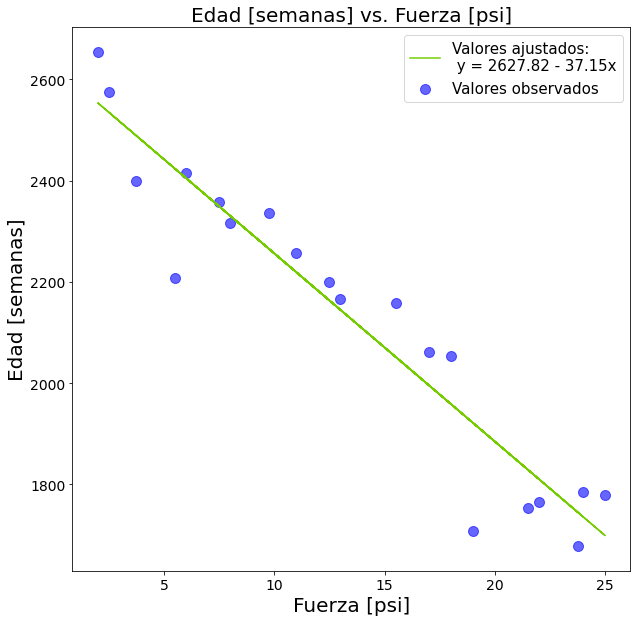

In [12]:
scatter_fit_plot(df, pretty_columns[0], pretty_columns[1], y_fit = pretty_columns[2], beta_0 = beta_0, beta_1 = beta_1)

In [55]:
working_columns = ["x", "y", "y_fit"]
df.columns = working_columns
test_beta_0(df, "x", "y", "y_fit", beta_0)
test_beta_1(df, "x", "y", "y_fit", beta_1)

Como |t_0| = 59.47 > -2.1 = t(𝛼/2, n-2), se rechaza la hipótesis nula H_0: 𝛽_0 = 0
Como |t_0| = 12.86 > -2.1 = t(𝛼/2, n-2), se rechaza la hipótesis nula H_0: 𝛽_1 = 0


In [56]:
test_analysis_of_variance(df, "y", "y_fit", alpha = 0.01)
    

Como |F_0| = 165.38 > 0.0 = F(𝛼, 1, n-2), se rechaza la hipótesis nula H_0: 𝛽_1 = 0


In [64]:
get_R_2(df, "y", "y_fit")
#get_y_bar(df, y)

0.9018

In [ ]:
# ESTA ES LA PRIMERA
working_columns = ["x", "y", "y_trans"]
df.columns = working_columns


df["y_fit"], beta_0, beta_1 = fit(df, "x", "y")
pretty_columns = ["Consumo eléctrico [kW/h]", 
                  "Consumo de agua [m$^2$/mes]", 
                  "Transformación de Consumo de agua [m$^2$/mes]",
                  "Ajuste lineal (respuesta original)"]
df.columns = pretty_columns

In [ ]:
scatter_fit_plot(df, pretty_columns[0], pretty_columns[1], y_fit = pretty_columns[3], beta_0 = beta_0, beta_1 = beta_1)

In [ ]:
working_columns = ["x", "y", "y_trans", "y_fit"]
df.columns = working_columns


df["y_fit_trans"], beta_0, beta_1 = fit(df, "x", "y_trans")
pretty_columns = ["Consumo eléctrico [kW/h]", 
                  "Consumo de agua [m$^2$/mes]", 
                  "Transformación de Consumo de agua [m$^2$/mes]",
                  "Ajuste lineal (respuesta original)", 
                  "Ajuste lineal (respuesta transformada)"]
df.columns = pretty_columns
                  
scatter_fit_plot(df, pretty_columns[0], pretty_columns[2], y_fit = pretty_columns[4], beta_0 = beta_0, beta_1 = beta_1)

# g) Construya un intervalo del 90% confianza para el consumo **medio** esperado si el consumo de energía eléctrica es de 7.57 kw/hr. (Nota: el intervalo es para el consumo de agua, no la respuesta transformada.).

In [89]:
alpha = 0.1
x_0 = 7.57
CI_lb, CI_ub = prediction_CI(df, "x", "y", "y_fit", x_0, beta_0, beta_1, alpha = alpha)
CI_lb = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_lb), 4)
CI_ub = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_ub), 4)

print(f"El valor y_0 ∈ ({CI_lb}, {CI_ub}) con {100*(1-alpha)} % de confianza para x_0 = {x_0}")

El valor y_0 ∈ (1.1675, 1.1973) con 90.0 % de confianza para x_0 = 7.57


# h) Construya un intervalo de predicción de 95 % para la demanda esperada si la generación de energía es de 5.1 kw/hr.

In [86]:
alpha = 0.05
x_0 = 5.1
CI_lb, CI_ub = prediction_CI(df, "x", "y", "y_fit", x_0, beta_0, beta_1, alpha = alpha)
CI_lb = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_lb), 4)
CI_ub = np.round(inv_box_cox_transformation_single_obs(df, "y", -0.25, CI_ub), 4)

print(f"El valor y_0 ∈ ({CI_lb}, {CI_ub}) con {100*(1-alpha)} % de confianza para x_0 = {x_0}")

El valor y_0 ∈ (1.1719, 1.2089) con 95.0 % de confianza para x_0 = 5.1
